# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [ ]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [ ]:
env = UnityEnvironment(file_name="Reacher20.app")

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [ ]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [ ]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [ ]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from collections import namedtuple, deque
import time
import copy

from shutil import copyfile
from IPython.display import display, clear_output
from unityagents import UnityEnvironment

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
def hidden_init(layer):
    fanin = layer.weight.data.size()[0]
    limit = 1. / np.sqrt(fanin)
    return (-limit, limit)

In [6]:
class Actor(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=256, fc2_units=128):
        """ 
        PARAMETERS: 
            state_size (int): Dimension of a state
            action_size (int): Dimension of an action
            seed (int): Rand seed
            fc1_units (int): No. of nodes in 1st hidden layer
            fc2_units (int): No. of nodes in 2nd hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3 , 3e-3)
    def forward(self , state):
        inp = F.relu(self.fc1(state))
        inp = F.relu(self.fc2(inp))
        return torch.tanh(self.fc3(inp))

In [7]:
class Critic(nn.Module):

    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=128):
        """ 
        PARAMETERS: 
            state_size (int): Dimension of a state
            action_size (int): Dimension of an action
            seed (int): Rand seed
            fcs1_units (int): No. of nodes in the first hidden layer
            fc2_units (int): No. of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()
    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
    def forward(self, state, action):
        x = F.relu(self.fcs1(state))
        x = torch.cat((x, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [8]:
class ReplayBuffer:
    
    def __init__(self, action_size, buffer_size, batch_size, seed):
        """
        PARAMETERS:
            buffer_size(int): Maximum buffer size
            batch_size(int): Training batch size 
        """
        self.action_size = action_size
        self.memory = deque(maxlen = buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        
    def sample(self):
        exps = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in exps if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in exps if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in exps if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in exps if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in exps if e is not None]).astype(np.uint8)).float().to(device)
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [9]:
class OUNoise: #Ornstein-Uhlenbeck process

    def __init__(self, size, seed, mu=0.0, theta=0.15, sigma=0.20):
        self.size = size
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        self.state = copy.copy(self.mu)

    def sample(self):
        x = self.state
        rnd = np.random.standard_normal(self.size)
        dx = self.theta * (self.mu - x) + self.sigma * rnd
        self.state = x + dx
        return self.state

In [10]:
class Agent():
    
    def __init__(self, num_agents, state_size, action_size, buffer_size, batch_size, learn_every, update_every, random_seed):
        """
        PARAMETERS:
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.num_agents = num_agents
        self.state_size = state_size
        self.action_size = action_size
        self.learn_every = learn_every
        self.update_every = update_every
        self.seed = random.seed(random_seed)
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr = lr_actor)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr = lr_critic, weight_decay = weight_decay)
        self.noise = OUNoise((num_agents,action_size), random_seed)
        self.memory = ReplayBuffer(action_size, self.buffer_size, self.batch_size, random_seed)
    
    def step(self, state, action, reward, next_state, done):
        for i in range(self.num_agents):
            self.memory.add(state[i,:], action[i,:], reward[i], next_state[i,:], done[i])
        self.i_step += 1            
        should_learn = (self.i_step % self.learn_every) == 0
        should_update = (self.i_step % self.update_every) == 0
        if len(self.memory) > self.batch_size:
            if should_learn:
                exps = self.memory.sample()
                self.learn(exps, gamma)
            if should_update:
                self.soft_update(self.critic_local, self.critic_target, tau)
                self.soft_update(self.actor_local, self.actor_target, tau) 

    def act(self, state, add_noise=True):
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()
        self.i_step=0

    def learn(self, exps, gamma):
        states, actions, rewards, next_states, dones = exps
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()                    

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [11]:
class Environment():
    
    def __init__(self,path):
        self.env = UnityEnvironment(file_name=path);
        self.brain_name = self.env.brain_names[0]
        self.brain = self.env.brains[self.brain_name]
        self.state_size = self.brain.vector_observation_space_size
        self.action_size = self.brain.vector_action_space_size
        info = self.env.reset(train_mode=True)[self.brain_name]
        self.num_agents = len(info.agents)
        
    def close(self):
        self.env.close()
    
    def reset(self,train=True):
        info = self.env.reset(train_mode=train)[self.brain_name]
        return info.vector_observations
    
    def step(self,action):
        info = self.env.step(action)[self.brain_name]
        state = info.vector_observations
        reward = info.rewards
        done = info.local_done
        return state, reward, done, info

In [12]:
env = Environment('Reacher20.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [17]:
batch_size = 64
buf_size = int(1e+5)
gamma = 0.99
tau = 1e-3
weight_decay = 0
lr_actor = 1e-4
lr_critic = 1e-4
update_step = 1
learn_step  = 1
rand_seed = 0

num_episodes = 200

session = str(int(time.time()))

agent_config = {
    'num_agents':env.num_agents,
    'state_size':env.state_size,
    'action_size':env.action_size,
    'buffer_size':buf_size,
    'batch_size':batch_size,
    'learn_every':learn_step,
    'update_every':update_step,
    'random_seed':rand_seed
}

agent = Agent(**agent_config)

def DDPG(n_episodes = num_episodes, max_t=1000):
    scores_deque = deque(maxlen=100)
    scores = []
    max_score = 0
    for i_episode in range(1, n_episodes+1):
        states = env.reset()
        agent.reset()
        score = np.zeros(env.num_agents)
        
        while True:
            actions = agent.act(states)
            next_states, rewards, dones, _ = env.step(actions)
            agent.step(states, actions, rewards, next_states, dones)
            score = score + rewards
            states = next_states
            if np.any(dones):
                break
        
        scores_deque.append(score)
        scores.append(score)
        avgscore_ep = np.mean(score)
        avgscore_100 = np.mean(scores_deque)
        print(f"Episode: {i_episode}/{num_episodes}\tScore: {avgscore_ep:.2f}\tAvgScore: {avgscore_100:.2f}")
        if avgscore_100>=30.0:
            print(f"***Solved! Episodes taken: {i_episode:d} AvgScore: {avgscore_100:.3f}***")
            if avgscore_100 > max_score:
                max_score = avgscore_100
                file_tpl = 'savedmodels/checkpoint_{}_{}_episode{}_score{:.3f}.pth'
                file_tpl_best = 'savedmodels/checkpoint_{}_{}_best.pth'
                fileactor = file_tpl.format(session,'actor', i_episode, avgscore_100)
                filecritic = file_tpl.format(session,'critic', i_episode, avgscore_100)
                torch.save(agent.actor_local.state_dict(), fileactor)
                torch.save(agent.critic_local.state_dict(), filecritic)
                copyfile(fileactor, file_tpl_best.format(session,'actor'))
                copyfile(filecritic, file_tpl_best.format(session,'critic'))         

    return scores

## 5. Training Process

In [18]:
scores = DDPG()

Episode: 1/200	Score: 0.65	AvgScore: 0.65
Episode: 2/200	Score: 0.62	AvgScore: 0.64
Episode: 3/200	Score: 0.51	AvgScore: 0.60
Episode: 4/200	Score: 0.65	AvgScore: 0.61
Episode: 5/200	Score: 0.60	AvgScore: 0.61
Episode: 6/200	Score: 0.81	AvgScore: 0.64
Episode: 7/200	Score: 0.94	AvgScore: 0.68
Episode: 8/200	Score: 1.17	AvgScore: 0.74
Episode: 9/200	Score: 1.17	AvgScore: 0.79
Episode: 10/200	Score: 1.37	AvgScore: 0.85
Episode: 11/200	Score: 2.24	AvgScore: 0.98
Episode: 12/200	Score: 1.83	AvgScore: 1.05
Episode: 13/200	Score: 1.84	AvgScore: 1.11
Episode: 14/200	Score: 1.90	AvgScore: 1.16
Episode: 15/200	Score: 1.90	AvgScore: 1.21
Episode: 16/200	Score: 2.38	AvgScore: 1.29
Episode: 17/200	Score: 2.58	AvgScore: 1.36
Episode: 18/200	Score: 2.06	AvgScore: 1.40
Episode: 19/200	Score: 3.08	AvgScore: 1.49
Episode: 20/200	Score: 3.48	AvgScore: 1.59
Episode: 21/200	Score: 5.09	AvgScore: 1.76
Episode: 22/200	Score: 4.80	AvgScore: 1.89
Episode: 23/200	Score: 5.22	AvgScore: 2.04
Episode: 24/200	Scor

Episode: 147/200	Score: 35.49	AvgScore: 36.21
***Solved! Episodes taken: 147 AvgScore: 36.214***
Episode: 148/200	Score: 36.70	AvgScore: 36.21
***Solved! Episodes taken: 148 AvgScore: 36.212***
Episode: 149/200	Score: 35.11	AvgScore: 36.19
***Solved! Episodes taken: 149 AvgScore: 36.189***
Episode: 150/200	Score: 35.47	AvgScore: 36.17
***Solved! Episodes taken: 150 AvgScore: 36.169***
Episode: 151/200	Score: 35.84	AvgScore: 36.15
***Solved! Episodes taken: 151 AvgScore: 36.153***
Episode: 152/200	Score: 36.40	AvgScore: 36.14
***Solved! Episodes taken: 152 AvgScore: 36.138***
Episode: 153/200	Score: 36.78	AvgScore: 36.14
***Solved! Episodes taken: 153 AvgScore: 36.145***
Episode: 154/200	Score: 35.80	AvgScore: 36.13
***Solved! Episodes taken: 154 AvgScore: 36.128***
Episode: 155/200	Score: 35.55	AvgScore: 36.11
***Solved! Episodes taken: 155 AvgScore: 36.113***
Episode: 156/200	Score: 35.47	AvgScore: 36.10
***Solved! Episodes taken: 156 AvgScore: 36.099***
Episode: 157/200	Score: 34.44	

## 6. Performance

In [19]:
import matplotlib.pyplot as plt

%matplotlib inline

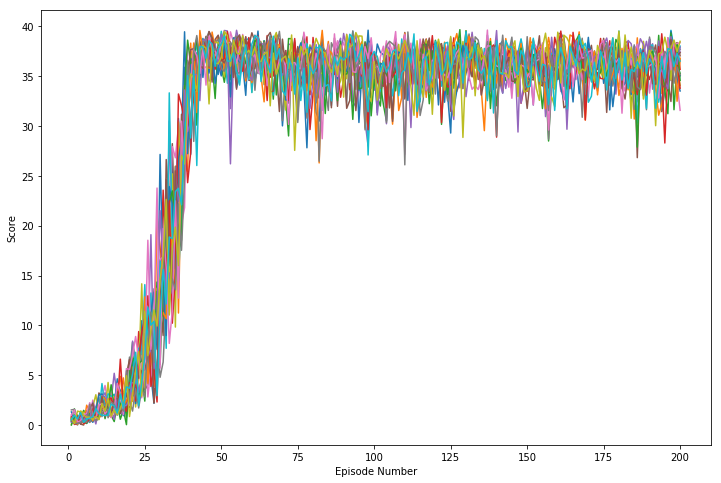

In [31]:
fig = plt.figure()
perf = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode Number')
plt.rcParams["figure.figsize"] = [18.0, 12.0]
plt.show()